In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import math
from shapely.geometry import Point
%matplotlib inline

In [2]:
df = pd.read_csv("NYPD_Motor_Vehicle_Collisions.csv", parse_dates=[['DATE', 'TIME']], infer_datetime_format=True)

Add the day of the week, Monday = 0, Sunday = 6

In [3]:
df['DAY_OF_WEEK'] = df['DATE_TIME'].dt.dayofweek

In [4]:
df["DATE_TIME"].min(0)

Timestamp('2012-07-01 00:05:00')

In [5]:
df["DATE_TIME"].max(0)

Timestamp('2017-03-11 23:50:00')

## Data is from 07/01/2012 to 03/11/2017

Look at how big the area is with: http://www.latlong.net/

In [6]:
step = 0.003
to_bin = lambda x: np.floor(x / step) * step
df["lat_bin"] = df.LATITUDE.map(to_bin)
df["long_bin"] = df.LONGITUDE.map(to_bin)

Take a dataframe and turn it into aggregate counts of unique instances

In [25]:
counts = pd.DataFrame(df.groupby(["lat_bin", "long_bin"])["UNIQUE KEY"].count()).reset_index()
counts = counts.drop(counts[(counts.long_bin > -70) | (counts.long_bin < -74.4)].index)

geometry = [Point(xy) for xy in zip(counts.long_bin, counts.lat_bin)]
counts = counts.drop(['long_bin', 'lat_bin'], axis=1)
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(counts, crs=crs, geometry=geometry)

In [27]:
geo_df['log_counts'] = geo_df['UNIQUE KEY'].apply(lambda x: np.log(x))
log_count_bins = pd.cut(geo_df.log_counts, 5, retbins=True)
exp_rebin = lambda x: "(%s]" % " - ".join([str(int(np.floor(np.exp(float(y))))).zfill(4) for y in x.strip("(").strip("]").split(", ")])
geo_df["counts"] = log_count_bins[0].apply(exp_rebin)

In [28]:
bins = [float(log_count_bins[0].unique()[0].split(", ")[0][1:])]
bins = bins + [float(x.split(", ")[1][:-1]) for x in log_count_bins[0].unique()]
bins.sort()

In [29]:
"""
stations = pd.read_csv("NY_Stations.csv")
station_geometry = [Point(xy) for xy in zip(stations.long, stations.lat)]
stations_geo = gpd.GeoDataFrame(stations, crs=crs, geometry=station_geometry)
"""

'\nstations = pd.read_csv("NY_Stations.csv")\nstation_geometry = [Point(xy) for xy in zip(stations.long, stations.lat)]\nstations_geo = gpd.GeoDataFrame(stations, crs=crs, geometry=station_geometry)\n'

In [30]:
"""
stations = pd.read_csv("Hourly_Precipitation.csv", usecols=["STATION_NAME", "LATITUDE", "LONGITUDE"])
stations = stations.drop_duplicates()
stations = stations.drop(stations[stations.LATITUDE == "unknown"].index)
stations = stations.drop([1299, 3104, 5053, 5060, 5063])
station_geometry = [Point(xy) for xy in zip(stations.LONGITUDE.astype(float), stations.LATITUDE.astype(float))]
stations_geo = gpd.GeoDataFrame(stations, crs=crs, geometry=station_geometry)
"""

'\nstations = pd.read_csv("Hourly_Precipitation.csv", usecols=["STATION_NAME", "LATITUDE", "LONGITUDE"])\nstations = stations.drop_duplicates()\nstations = stations.drop(stations[stations.LATITUDE == "unknown"].index)\nstations = stations.drop([1299, 3104, 5053, 5060, 5063])\nstation_geometry = [Point(xy) for xy in zip(stations.LONGITUDE.astype(float), stations.LATITUDE.astype(float))]\nstations_geo = gpd.GeoDataFrame(stations, crs=crs, geometry=station_geometry)\n'

In [31]:
key_points = pd.read_csv("key_points.csv")
key_points = key_points.drop([8])
key_points_geometry = [Point(xy) for xy in zip(key_points.long, key_points.lat)]
key_points_geo = gpd.GeoDataFrame(key_points, crs=crs, geometry=key_points_geometry)

In [32]:
def annotate(geo_df, feature):
    #geo_df.plot(ax=ax, color='blue', markersize=5)
    geo_df['coords'] = geo_df['geometry'].apply(lambda x: x.representative_point().coords[:])
    geo_df['coords'] = [coords[0] for coords in geo_df['coords']]
    for idx, row in geo_df.iterrows():
        plt.annotate(s=row[feature], xy=row['coords'],
                     ha='center', va='bottom', backgroundcolor='white')

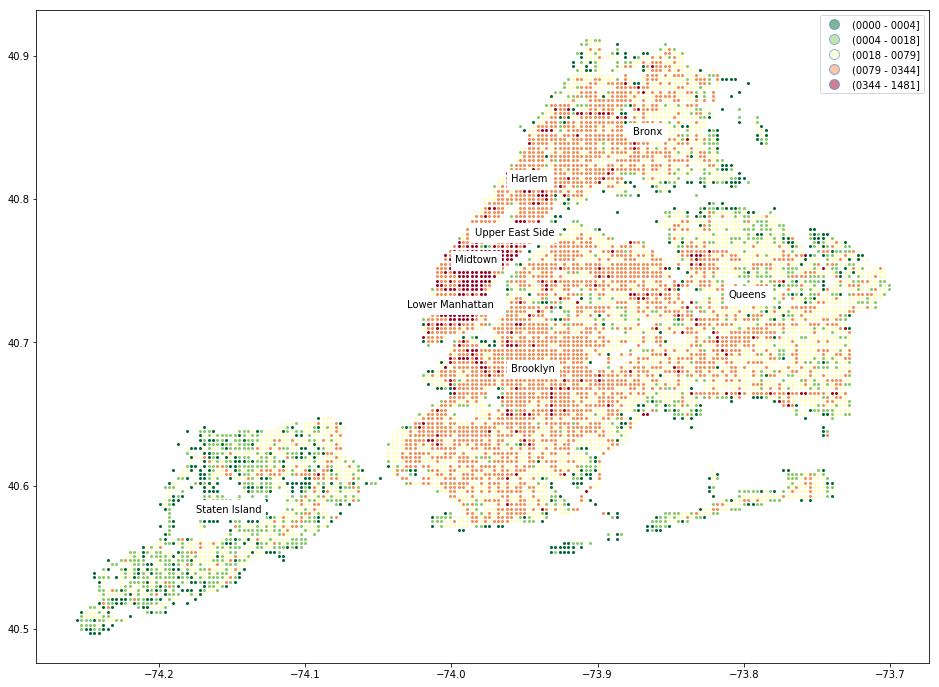

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (16,12))

geo_df.plot(column="counts", cmap="RdYlGn_r", categorical=True, legend=True, ax=ax)

annotate(key_points_geo, 'name')

## Explore injuries

(0, 10)

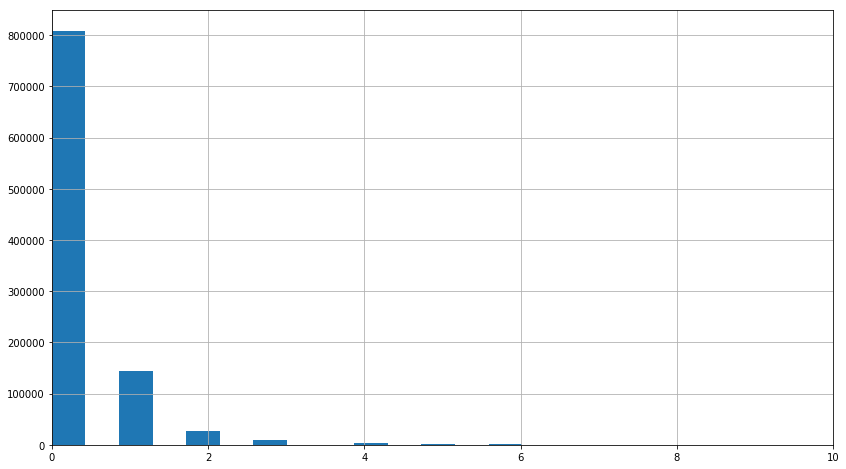

In [15]:
df["NUMBER OF PERSONS INJURED"].hist(bins=100, figsize=(14,8))
plt.xlim(0, 10)

In [16]:
len(df[(df["NUMBER OF PERSONS INJURED"] > 0)])

185638

In [17]:
df["injured_or_killed"] = ((df["NUMBER OF PERSONS INJURED"] > 0) | (df["NUMBER OF PERSONS KILLED"] > 0)).astype(int)

In [18]:
counts = pd.DataFrame(df.groupby(["lat_bin", "long_bin"])["injured_or_killed"].mean()).reset_index()
counts = counts.drop(counts[(counts.long_bin > -70) | (counts.long_bin < -74.4)].index)
geometry = [Point(xy) for xy in zip(counts.long_bin, counts.lat_bin)]
counts = counts.drop(['long_bin', 'lat_bin'], axis=1)
crs = {'init': 'epsg:4326'}
injured_geo_df = gpd.GeoDataFrame(counts, crs=crs, geometry=geometry)

In [19]:
injured_geo_df

,injured_or_killed,geometry
1,0.000000,POINT (-74.247 40.497)
2,0.500000,POINT (-74.244 40.497)
3,0.000000,POINT (-74.241 40.497)
4,0.166667,POINT (-74.253 40.5)
5,0.000000,POINT (-74.25 40.5)
6,0.000000,POINT (-74.247 40.5)
7,0.142857,POINT (-74.244 40.5)
8,0.000000,POINT (-74.241 40.5)
9,0.000000,POINT (-74.238 40.5)
10,0.250000,POINT (-74.235 40.5)


In [23]:
injured_geo_df['% injured'] = pd.cut(injured_geo_df.injured_or_killed, 5)

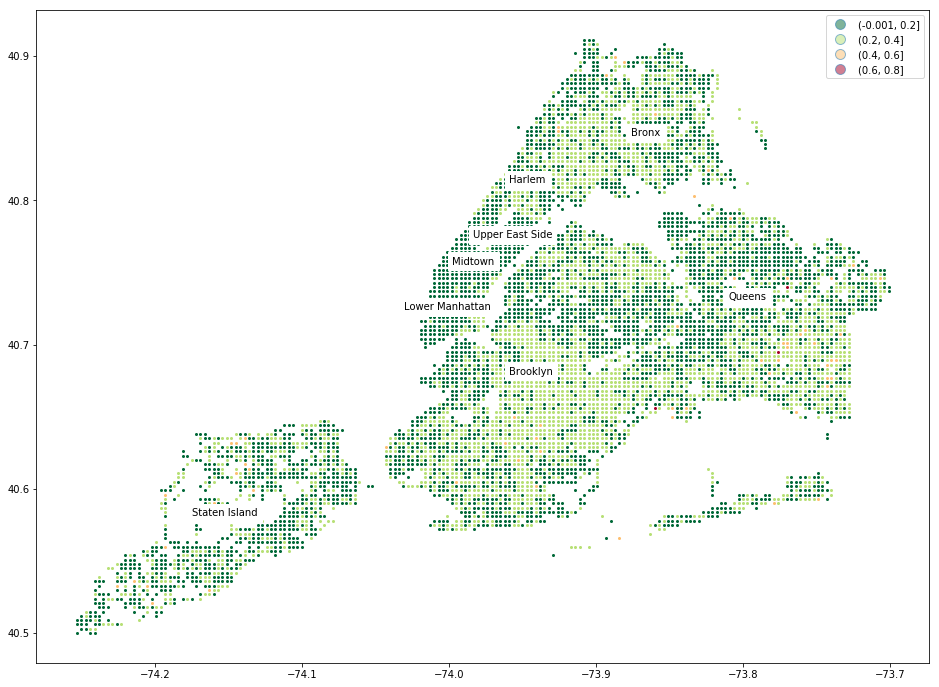

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (16,12))

injured_geo_df[geo_df["UNIQUE KEY"] > 5].plot(column="% injured", cmap="RdYlGn_r", categorical=True, legend=True, ax=ax)

annotate(key_points_geo, 'name')

## Explore hourly precipitation data

This hourly precipitation data is from 8/2012 to 6/2016

In [22]:
mongaup_valley = pd.read_csv("USC00305435.hly", header=None, delim_whitespace=True)
mongaup_valley["year"] = mongaup_valley[0].apply(lambda x: int(x[11:15]))
mongaup_valley["month"] = mongaup_valley[0].apply(lambda x: int(x[15:17]))
mongaup_valley["day"] = mongaup_valley[0].apply(lambda x: int(x[17:19]))
mongaup_valley.drop(mongaup_valley[mongaup_valley["year"] < 2012].index, inplace=True)
mongaup_valley

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,year,month,day
9325,USC0030543520120401HPCP,0g,4,-9999,M4,-9999,M4,-9999,M4,-9999,...,M4,-9999,M4,-9999,M4,-9999,M4,2012,4,1
9326,USC0030543520120816HPCP-9999,M4,-9999,M4,-9999,M4,-9999,M4,-9999,M4,...,0Z,4,0Z,4,0Z,4,NaN,2012,8,16
9327,USC0030543520120817HPCP,0,HC,0,HC,0,HC,0,HC,0,...,HC,0,HC,0,HC,0,HC,2012,8,17
9328,USC0030543520120818HPCP,0,HC,1,HC,0,HC,2,HC,0,...,HC,0,HC,0,HC,0,HC,2012,8,18
9329,USC0030543520120819HPCP,0,HC,0,HC,0,HC,0,HC,0,...,HC,0,HC,0,HC,0,HC,2012,8,19
9330,USC0030543520120820HPCP,0,HC,0,HC,0,HC,0,HC,0,...,HC,0,HC,0,HC,0,HC,2012,8,20
9331,USC0030543520120821HPCP,0,HC,0,HC,0,HC,0,HC,0,...,HC,0,HC,0,HC,0,HC,2012,8,21
9332,USC0030543520120822HPCP,0,HC,0,HC,0,HC,0,HC,0,...,HC,0,HC,0,HC,0,HC,2012,8,22
9333,USC0030543520120823HPCP,0,HC,0,HC,0,HC,0,HC,0,...,HC,0,HC,0,HC,0,HC,2012,8,23
9334,USC0030543520120824HPCP,0,HC,0,HC,0,HC,0,HC,0,...,HC,0,HC,0,HC,1,HC,2012,8,24
